# CS3244 Machine Learning Team Project
## Prediction of the number of dengue cases in Singapore

First, we shall import necessary Python libraries.

In [23]:
# Import data processing tools
import pandas as pd
import numpy as np

# Import visualization tools
import matplotlib.pyplot as plt

# Import utility tools
import requests
from math import *
from datetime import datetime
from datetime import timedelta

# Import ML tools
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

We shall read from various CSV files to extract dataframe for each feature in the following cells:
* Weekly **dengue** cases (*dengue_df*)
* Annual **population** (*population_df*)
* Monthly mean **sunshine** hours (*sunshine_df*)
* Monthly **surface air temperature** (*surface_air_temperature_df*)

In [100]:
# Read weekly dengue cases from csv files
raw_dengue_df = pd.read_csv(
    "Datasets/Dengue Cluster Data/weekly-number-of-dengue-and-dengue-haemorrhagic-fever-cases.csv")

# Clean data by filtering by type_dengue and remove the redundant column
dengue_df = raw_dengue_df[raw_dengue_df['type_dengue'].map(
    lambda x: str(x) == "Dengue")].drop('type_dengue', 1).reset_index()

# Rename eweek to week
dengue_df = dengue_df.rename(columns={"eweek": "week"}, errors="raise")
# Display first 5 rows of the dataframe
dengue_df.head()

,index,year,week,number
0,0,2014,1,436.0
1,2,2014,2,479.0
2,4,2014,3,401.0
3,6,2014,4,336.0
4,8,2014,5,234.0


In [101]:
# Read from CSV
raw_population_df = pd.read_csv(
    "Datasets/Population Data/singapore-residents-by-age-group-ethnic-group-and-sex-end-june-annual.csv")
# Only get data from 2014 to 2018
population_df = raw_population_df[raw_population_df['year'].map(
    lambda x: 2014 <= int(x) <= 2018)]
# Only get total residents for each year
population_df = population_df[population_df['level_1'].map(
    lambda x: str(x) == 'Total Residents')].drop('level_1', 1).drop('level_2', 1)
population_df = population_df.astype({'year' : 'int32', 'value': 'int32'})
population_df = population_df.groupby('year').sum()
population_df = population_df.rename(columns={"value": "population"}, errors="raise")
# Display dataframe
population_df.head()

,population
year,
2014,4823625
2015,4907802
2016,4994232
2017,5089716
2018,5184977


In [130]:
# Read from CSV
raw_sunshine_df = pd.read_csv("Datasets/Sunshine Data/sunshine-duration-monthly-mean-daily-duration.csv")
# Split year_month into year and month column
raw_sunshine_df = raw_sunshine_df.rename(columns={"month": "year_month"}, errors="raise")
year_col = pd.Series([], dtype='int32')
month_col = pd.Series([], dtype='int32')
for i in range(len(raw_sunshine_df)):
    year_col[i] = int(raw_sunshine_df['year_month'][i].split('-')[0])
    month_col[i] = int(raw_sunshine_df['year_month'][i].split('-')[1])
raw_sunshine_df.insert(1, 'year', year_col)
raw_sunshine_df.insert(2, 'month', month_col)
sunshine_df = raw_sunshine_df.drop('year_month', 1)
# Display
sunshine_df.head()

,year,month,mean_sunshine_hrs
0,1982,1,5.6
1,1982,2,7.6
2,1982,3,5.1
3,1982,4,4.7
4,1982,5,5.8


In [144]:
# Read from CSV
raw_temperature_df = pd.read_csv(
    "Datasets/Surface Air Temperature Data/surface-air-temperature-monthly-mean-daily-maximum.csv")
# Split year_month into year and month column
raw_temperature_df = raw_temperature_df.rename(columns={"month": "year_month"}, errors="raise")
year_col = pd.Series([], dtype='int32')
month_col = pd.Series([], dtype='int32')
for i in range(len(raw_temperature_df)):
    year_col[i] = int(raw_temperature_df['year_month'][i].split('-')[0])
    month_col[i] = int(raw_temperature_df['year_month'][i].split('-')[1])
raw_temperature_df.insert(1, 'year', year_col)
raw_temperature_df.insert(2, 'month', month_col)
surface_air_temperature_df = raw_temperature_df.drop('year_month', 1)
# Display
surface_air_temperature_df.head()

,year,month,temp_mean_daily_max
0,1982,1,29.8
1,1982,2,32.3
2,1982,3,31.7
3,1982,4,31.4
4,1982,5,31.7


Next, we shall merge the dataframes into one general dataframe **df** based on *year*, *month* and *week*.

In [146]:
# Merge dengue_df and population_df by year
df = dengue_df.merge(population_df, left_on='year', right_on='year').drop('index', 1)

# Create new column for cases_per_capita = number / population
# Create new column for month = (datetime(year, 1, 1) + timedelta(days=week*7)).momth
cases_per_capita = pd.Series([], dtype='float64')
month = pd.Series([], dtype='int32')
for i in range(len(df)):
    if isnan(df['number'][i]):
        cases_per_capita[i] = 0
    else:
        cases_per_capita[i] = int(df['number'][i]) / int(df['population'][i])
    year = int(df['year'][i])
    week = int(df['week'][i])
    if week > 52:
        month[i] = 12
    else:
        month[i] = (datetime(year, 1, 1) + timedelta(days=7*week)).month
df.insert(4, 'cases_per_capita', cases_per_capita)
df.insert(1, 'month', month)

# Merge sunshine and surface air temperature dataframe
df = pd.merge(df, sunshine_df, on=['year', 'month'])
df = pd.merge(df, surface_air_temperature_df, on=['year', 'month'])

# Display dataframe
df.head()

,year,month,week,number,population,cases_per_capita,mean_sunshine_hrs,temp_mean_daily_max
0,2014,1,1,436.0,4823625,0.000090,5.3,29.6
1,2014,1,2,479.0,4823625,0.000099,5.3,29.6
2,2014,1,3,401.0,4823625,0.000083,5.3,29.6
3,2014,1,4,336.0,4823625,0.000070,5.3,29.6
4,2014,2,5,234.0,4823625,0.000049,8.8,31.9


In [53]:
# Scrape from websites
base_url = "http://www.weather.gov.sg/files/dailydata/DAILYDATA_" #S24_201911.csv

# (East) Changi = 24, (West) Tuas South = 115, (North) Khatib = 122, (South) Marina Barrage = 108
# (Central) Ang Mo Kio = 109
station_dict = {24: 'Changi', 115: 'Tuas South', 122: 'Khatib', 108: 'Marina Barrage', 109: 'Ang Mo Kio'}
stations_list = [24, 115, 122, 108, 109]

# DataFrame template
df_template = pd.DataFrame(columns = ['Station', 'Year', 'Month', 'Day', 'Daily Rainfall Total (mm)',
       'Highest 30 Min Rainfall (mm)', 'Highest 60 Min Rainfall (mm)',
       'Highest 120 Min Rainfall (mm)', 'Mean Temperature (°C)',
       'Maximum Temperature (°C)', 'Minimum Temperature (°C)',
       'Mean Wind Speed (km/h)', 'Max Wind Speed (km/h)'])
weather_df = df_template.copy()

# Scrape stations and combine into a single csv file
for station in stations_list:
    station_string = "S"+str(station) if (station>9) else "S0"+str(station)
    station_df = df_template.copy()
    for year in range(2014,2020):
        for month in range(1,13):
            month_string = str(month) if (month>9) else "0"+str(month)
            url = base_url+station_string+"_"+str(year)+month_string+".csv"
            # Get csv files to temp files, and store into DataFrame
            try:
                r = requests.get(url, allow_redirects=True)
                open('temp.csv', 'wb').write(r.content)
                station_df = station_df.append(pd.read_csv("temp.csv", encoding = "ISO-8859-1"))
                weather_df = weather_df.append(pd.read_csv("temp.csv", encoding = "ISO-8859-1"))
            except:
                print(url)
                continue
    # Store into weather data folder
    csv_filename = 'Datasets/Weather Data/' + station_dict[station] + '.csv'
    station_df.to_csv(csv_filename, index=False)

,Station,Year,Month,Day,Daily Rainfall Total (mm),Highest 30 Min Rainfall (mm),Highest 60 Min Rainfall (mm),Highest 120 Min Rainfall (mm),Mean Temperature (°C),Maximum Temperature (°C),Minimum Temperature (°C),Mean Wind Speed (km/h),Max Wind Speed (km/h)
0,Changi,2014,1,1,0,0,0,0,26.7,29,24.9,10,29.9
1,Changi,2014,1,2,0,0,0,0,27.4,30.9,25,11.9,36
2,Changi,2014,1,3,0,0,0,0,27.1,30.4,24.9,9.7,33.1
3,Changi,2014,1,4,0,0,0,0,27.1,31.1,24.9,6.4,25.9
4,Changi,2014,1,5,18.4,8.6,10.8,15.4,24.8,26.4,23.3,6.8,25.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
26,Ang Mo Kio,2019,12,27,0,0,0,0,27.5,32.2,24.9,16.6,39.2
27,Ang Mo Kio,2019,12,28,0,0,0,0,27,31.1,24.7,16.9,41.8
28,Ang Mo Kio,2019,12,29,0.2,0.2,0.2,0.2,27.3,30.9,24.9,17.3,43.2
29,Ang Mo Kio,2019,12,30,0,0,0,0,27.6,32.3,24.9,16.6,35.3


Next, we can visualize the data.

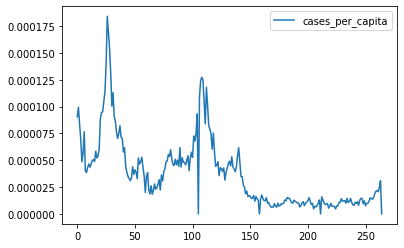

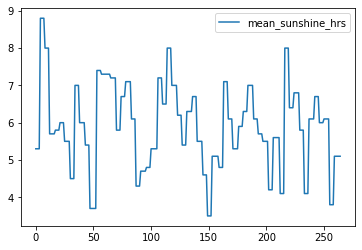

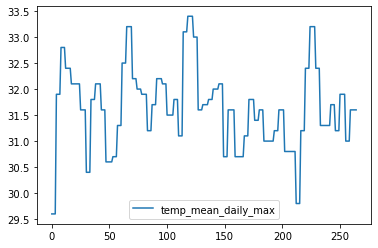

In [153]:
# Copy the dataframe, not to corrupt the original
vis_df = df.copy()
x_data = range(0, vis_df.shape[0])

# columns to visualize
columns = ['cases_per_capita', 'mean_sunshine_hrs', 'temp_mean_daily_max']

# plot line graphs
for column in columns:
    f = plt.figure()
    ax = f.add_subplot()
    ax.plot(x_data, vis_df[column], label=column)
    ax.legend()

In [ ]:
# fix random seed for reproducibility
np.random.seed(7)

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

